In [2]:
!git clone https://github.com/fpg2012/vq-vae.git

Cloning into 'vq-vae'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 18 (delta 1), reused 18 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (18/18), 4.64 MiB | 9.85 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [5]:
import sys
sys.path.append('vq-vae')
import argparse
import torch
import logging
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from matplotlib import pyplot as plt
from torchvision.utils import make_grid
from torchvision.transforms.functional import to_pil_image
import torch.nn.functional as F

from model.vq_vae import VectorQuantize
from model.ar import ARGenerator

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
vqvae = torch.load('vq-vae/vq-best.safetensors', weights_only=False, map_location=device).to(device)
model = ARGenerator(n_class=10, max_len=49, n_blocks=2, d_embedding=128, d_model=64, vocab_size=128, device=device).to(device)

In [17]:
class ARTrainer:

    def __init__(self, train_set, test_set, batch_size = 16, shuffle = True, device = 'cpu'):
        super(ARTrainer, self).__init__()
        self.train_set = train_set
        self.test_set = test_set
        self.batch_size = batch_size
        self.device = device
        self.seq_len = 7*7

        self.train_loader = DataLoader(train_set, batch_size=self.batch_size, shuffle=shuffle)
        self.test_loader = DataLoader(test_set, batch_size=self.batch_size, shuffle=shuffle)

    def train(self, model: ARGenerator, vqvae: VectorQuantize, epoch = 10, lr = 1e-3):
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
        vqvae.eval()
        if self.device == 'xpu':
            import intel_extension_for_pytorch as ipex
            model, optimizer = ipex.optimize(model, optimizer=optimizer)
        print(f'device: {self.device}')
        for i in range(epoch):
            print(f'epoch {i+1}')
            size = len(self.train_set)

            model.train()
            for batch, (X, y) in enumerate(self.train_loader):
                X, y = X.to(self.device), y.to(self.device)
                optimizer.zero_grad()

                with torch.no_grad():
                    indx, quantized = vqvae.encode(X)

                seq = torch.cat([model.sos_tokens(y)[:, None, :], quantized.detach()], dim=1).to(self.device)

                logits = model.forward(seq)
                logits = logits[:, :-1, :].reshape(X.shape[0] * self.seq_len, -1)
                target = indx.reshape(X.shape[0] * self.seq_len).detach().to(self.device)
                loss = F.cross_entropy(logits, target)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()

                if batch % 100 == 0:
                    loss, current = loss.item(), (batch + 1) * len(X)
                    print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

            torch.save(model, f'ar-epoch{i+1:>02d}.pth')

            total_loss = 0
            model.eval()
            with torch.no_grad():
                for _, (X, y) in enumerate(self.test_loader):
                    X, y = X.to(self.device), y.to(device)
                    indx, quantized = vqvae.encode(X)

                    seq = torch.cat([model.sos_tokens(y)[:, None, :], quantized], dim=1).to(device)

                    logits = model.forward(seq)
                    loss = F.cross_entropy(logits[:, :-1, :].reshape(X.shape[0] * self.seq_len, -1), indx.view(X.shape[0] * self.seq_len))
                    total_loss += loss.item()
            print(f'test loss: {total_loss/len(self.test_loader):>7f}')

            torch.xpu.empty_cache()

In [18]:
trainer = ARTrainer(MNIST(root='data', train=True, transform=ToTensor(), download=True), MNIST(root='data', train=False, transform=ToTensor(), download=True), batch_size=512, device=device)

In [19]:
trainer.train(model, vqvae=vqvae, epoch=20, lr=1e-3)

device: cuda
epoch 1
loss: 1.345473  [  512/60000]
loss: 1.248888  [51712/60000]
test loss: 1.252886
epoch 2
loss: 1.268196  [  512/60000]
loss: 1.225267  [51712/60000]
test loss: 1.185992
epoch 3
loss: 1.181586  [  512/60000]
loss: 1.147518  [51712/60000]
test loss: 1.157775
epoch 4
loss: 1.152145  [  512/60000]
loss: 1.121986  [51712/60000]
test loss: 1.121465
epoch 5
loss: 1.128020  [  512/60000]
loss: 1.121665  [51712/60000]
test loss: 1.102374
epoch 6
loss: 1.130791  [  512/60000]
loss: 1.090707  [51712/60000]
test loss: 1.086545
epoch 7
loss: 1.074440  [  512/60000]
loss: 1.090536  [51712/60000]
test loss: 1.079924
epoch 8
loss: 1.098099  [  512/60000]
loss: 1.068557  [51712/60000]
test loss: 1.064160
epoch 9
loss: 1.067505  [  512/60000]
loss: 1.071272  [51712/60000]
test loss: 1.054706
epoch 10
loss: 1.072775  [  512/60000]
loss: 1.046092  [51712/60000]
test loss: 1.046747
epoch 11
loss: 1.041499  [  512/60000]
loss: 1.025056  [51712/60000]
test loss: 1.040388
epoch 12
loss: 1.

In [20]:
def ar_genearte(label: torch.Tensor, vqvae, ar, temperature = 1):
    B = label.shape[0]
    sos = ar.sos_tokens(label)
    print('sos', sos.shape)
    x = sos.unsqueeze(1)
    for i in range(ar.max_len):
        logits = ar.forward(x)
        # print('logits', logits.shape)
        logit = logits[:, -1, :]
        # print('logit', logit.shape)
        logit = F.softmax(logit / temperature, dim=1)
        indx = torch.multinomial(logit, 1)
        # print('indx', indx.shape)
        quantized = vqvae.codebook(indx)
        # print('quantized', quantized.shape)
        x = torch.concat([x, quantized], dim=1)
    generated = vqvae.decode(x[:, 1:])
    return generated

In [40]:
from torchvision.utils import make_grid

sos torch.Size([40, 128])
torch.Size([40, 1, 28, 28])


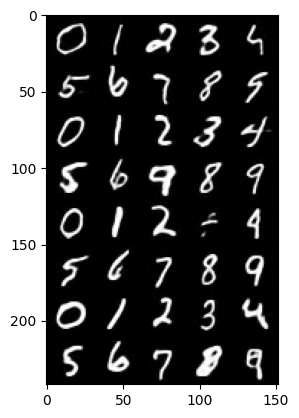

In [44]:
generated = ar_genearte(torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9] * 4).to(device), vqvae, model, temperature=0.75)
plt.imshow(make_grid(generated, nrow=5).permute(1, 2, 0).detach().cpu().numpy(), cmap='gray')
print(generated.shape)